# New Metric - Change in Covariance Structure

April 28, 2022

TO DO: THIS NOTEBOOK NEEDS TO BE CLEANED UP

What can we say about what the change in covariance should look like? I would like to create a new metric that uses the covariance.

This is a pretty similar approach to the "flow field" metric that I used before. I still have to estimate a change in the recurrent weights $\Delta \mathbf{W}^{\mathrm{rec}}$ based on either $(\mathbf{W}^{\mathrm{bmi}})^\top$ or on $\mathbf{M}$, and chunk the neural activity before, during, and after learning.

$$ \Delta \mathrm{Cov}^{data} = \mathrm{Cov}(h^{after}) - \mathrm{Cov}(h^{before})$$

$$ \Delta \mathrm{Cov}^{pred} = \mathrm{Cov}(h^{before}+\Delta W h^{before}) - \mathrm{Cov}(h^{before})$$

I can then correlate $ \Delta \mathrm{Cov}^{data} \cdot \Delta \mathrm{Cov}^{pred}$

Alternatively, I could correlate $ \mathrm{Cov}(h^{after})$ with $ \mathrm{Cov}(h^{before}+\Delta W h^{before})$, and see if that yields similar results.

I think this is working correctly, although I should probably check more carefully.

I also think this is complimented nicely by correlating the change of weights directly - it is very illustrative

current directory: `rnn-learning/experiments/Analytics-2022-4-20`

In [268]:
pwd

'/Users/jacobportes/Documents/Code/rnn-learning/experiments/Analytics-2022-4-20'

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# analysis
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.linear_model import LinearRegression
from scipy import stats, interpolate
from scipy import linalg as LA
from scipy.ndimage.filters import uniform_filter1d

# miscellaneous
from tqdm import tqdm
from itertools import cycle
from copy import deepcopy

import logging
import warnings
import dataclasses
from dataclasses import dataclass
from typing import Optional, List

import sys
sys.path.append("../..")

In [2]:
from rnn import RNNparams, RNN
from task import Task
from simulation import Simulation
from algorithms.bptt import BPTT
from algorithms.rflo import RFLO
from algorithms.reinforce import REINFORCE
from algorithms.track_vars import TrackVars

from utils.plotting import plot_trained_trajectories
from utils.metric import cos_sim, return_norm_and_angle
from utils.functions import choose_aligned_matrix

from utils.metric import cos_sim, flow_field_data, flow_field_predicted, calculate_flow_field_correlation


### Train RNN on four targets

Note here that the input is only "on" for 20% of the trial.

In [3]:
trial_duration = 20
n_in=4
frac_on = 1.0

x_tonic = 0.0*np.ones((trial_duration, n_in)) # shape 20 x 4 i.e. time x channel
x_pulse1 = x_tonic.copy()
x_pulse2 = x_tonic.copy()
x_pulse3 = x_tonic.copy()
x_pulse4 = x_tonic.copy()
x_pulse1[0:int(trial_duration*frac_on),0] = 1
x_pulse2[0:int(trial_duration*frac_on),1] = 1
x_pulse3[0:int(trial_duration*frac_on),2] = 1
x_pulse4[0:int(trial_duration*frac_on),3] = 1

task1 = Task(x_in=x_pulse1,y_target=np.asarray([[1],[1]]))
task2 = Task(x_in=x_pulse2,y_target=np.asarray([[-1],[1]]))
task3 = Task(x_in=x_pulse3,y_target=np.asarray([[1],[-1]]))
task4 = Task(x_in=x_pulse4,y_target=np.asarray([[-1],[-1]]))

14it [00:00, 139.55it/s]

n_in: 4
n_rec: 50
n_out: 2
sig_in: 0.0
sig_rec: 0.25
sig_out: 0.01
tau_rec: 10
dt: 1.0
eta_in: 0.1
eta_rec: 0.1
eta_out: 0.1
g_in: 2.0
g_rec: 1.5
g_out: 2.0
g_fb: 2.0
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: False
tau_vel: 0.8
dt_vel: 0.1
sig_rec_dim: None
eta_m: None
sig_m: None
lam_m: None
rng: <mtrand.RandomState object at 0x7fd49f1b5b40>


2500it [00:06, 370.16it/s]


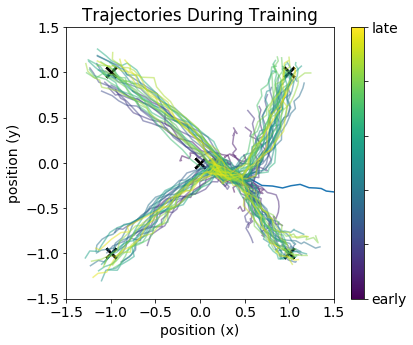

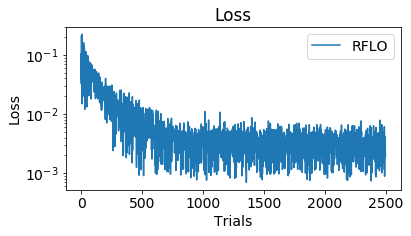

In [4]:
# Set RNN Parameters
params = RNNparams(n_in=4,n_rec=50,n_out=2,tau_rec=10,
               eta_in=0.1,eta_rec=0.1,eta_out=0.1,
               sig_in=0.0,sig_rec=0.25,sig_out=0.01,
               velocity_transform=False, tau_vel = 0.8, dt_vel = 0.1,
               rng=np.random.RandomState(72))
params.print_params()

# Initialize RNN
net0 = RNN(params)
sim0 = Simulation(net0)
rflo = RFLO(net0,apply_to=['w_rec'],online=False)
sim0.run_session(n_trials=2500, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=['loss'], plot=True, plot_freq=20)




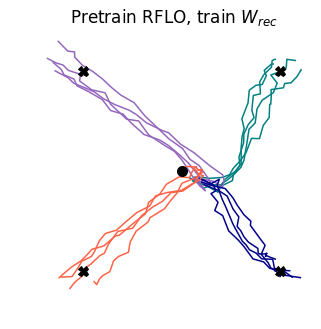

In [5]:
fig0 = plot_trained_trajectories(sim=sim0, tasks=[task1,task2,task3,task4],title='Pretrain RFLO, train '+r'$W_{rec}$')


## Part 1 - Apply gradient calculation to two separate learning rules

First we choose a new decoder `w_out1` such that it has an overlap alignment of 0.6 with the old decoder `w_out0`.

Then we define an "internal model of credit assignment" matrix `w_m` that overlaps with the new decoder by 0.6.

Since these are selected randomly, the overlap of the internal model `w_m` with the old decoder `w_out0` is lower, i.e. 0.3

In [6]:
overlap = 0.6
n_change = 50
w_out1 = choose_aligned_matrix(net0.w_out.copy(),n_change=n_change,overlap=overlap,zero=False,tolerance=0.01,loop=1000)
w_m = choose_aligned_matrix(w_out1,n_change=n_change,overlap=overlap,zero=False,tolerance=0.01,loop=1000)

# confirm overlap between w_out1 and w_out
norm, angle = return_norm_and_angle(net0.w_out,w_out1)
print('\nw_out1 norm: {:.2f}'.format(norm) + '\t w_out vs. w_out1 angle: {:.2f}'.format(angle),end='')

# confirm overlap between w_out1 and w_m
norm, angle = return_norm_and_angle(w_out1,w_m)
print('\nw_m norm: {:.2f}'.format(norm) + '\t w_out1 vs. w_m angle: {:.2f}'.format(angle),end='')

# confirm overlap between w_out and w_m
norm, angle = return_norm_and_angle(net0.w_out,w_m)
print('\nw_m norm: {:.2f}'.format(norm) + '\t w_out vs. w_m angle: {:.2f}'.format(angle),end='')

M norm: 1.08	 M angle: 0.59, 6 iterations
w_out1 norm: 1.36	 w_out vs. w_out1 angle: 0.60
w_m norm: 1.08	 w_out1 vs. w_m angle: 0.59
w_m norm: 1.65	 w_out vs. w_m angle: 0.35

## Train with RFLO

500it [00:00, 806.17it/s]
1500it [00:05, 265.71it/s]
500it [00:00, 884.02it/s]


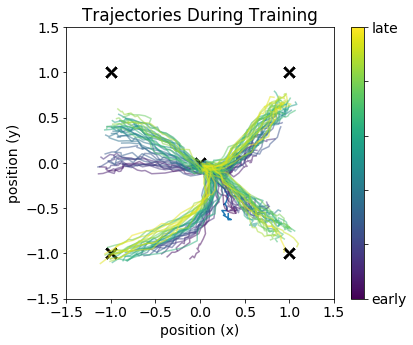

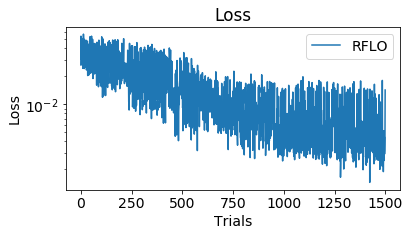

In [7]:
net1_pre = RNN(params)
net1_pre.set_weights(w_in=net0.w_in.copy(), w_rec=net0.w_rec.copy())
net1_pre.set_weights(w_out = w_out1)
net1_pre.set_weights(w_m = w_m.T)

# unfortunately I need to make a different network to maintain integrity of pre and post simulations for plotting
net1 = RNN(params)
net1.set_weights(w_in=net0.w_in.copy(), w_rec=net0.w_rec.copy())
net1.set_weights(w_out = w_out1)
net1.set_weights(w_m = w_m.T)




""" Track activity with new decoder, before training """

sim1_pre = Simulation(net1_pre)
trackvars = TrackVars(net1_pre,apply_to=[]) 
sim1_pre.run_session(n_trials=500, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h','err'], plot=False, plot_freq=10)
#fig = plot_trained_trajectories(sim=sim1_pre, tasks=[task1,task2,task3,task4],title='RFLO, before training with new decoder')

""" Train with new decoder """

sim1_train = Simulation(net1)
rflo = RFLO(net1,apply_to=['w_rec'],online=False)
sim1_train.run_session(n_trials=1500, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=['h','loss','err'], plot=True, plot_freq=10)

""" Track activity with new decoder, after training """
net1_post = RNN(params)
net1_post.set_weights(w_in=net1.w_in.copy(), w_rec=net1.w_rec.copy())
net1_post.set_weights(w_out = net1.w_out)
net1_post.set_weights(w_m = net1.w_m)

sim1_post = Simulation(net1_post)
trackvars = TrackVars(net1_post,apply_to=[]) 
sim1_post.run_session(n_trials=500, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h','err'], plot=False, plot_freq=10)


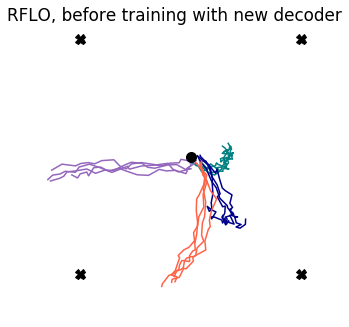

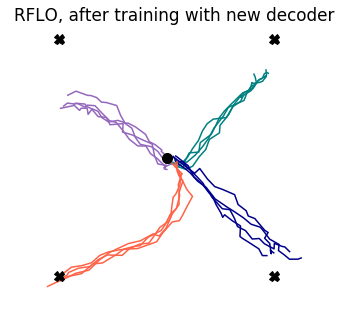

In [8]:
fig = plot_trained_trajectories(sim=sim1_pre, tasks=[task1,task2,task3,task4],title='RFLO, before training with new decoder')

fig = plot_trained_trajectories(sim=sim1_post, tasks=[task1,task2,task3,task4],title='RFLO, after training with new decoder')


## Calculate Covariance Before and After Learning

similarity pre post: 0.688


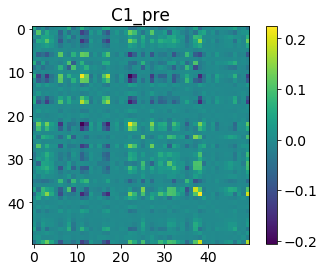

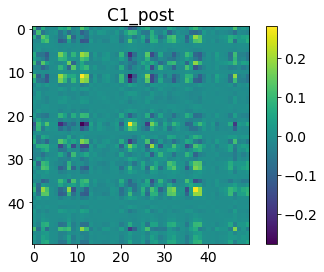

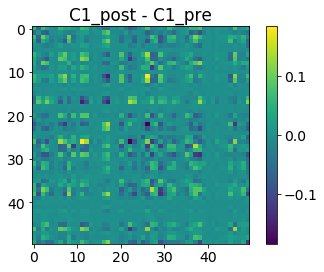

In [9]:
t_ind = 10

""" Covariance Before """
h1_pre = np.asarray(sim1_pre.session_probes['h']).squeeze()

C1_pre = np.cov(h1_pre[:,t_ind,:].T) # neurons x trials at a single time point

""" Covariance After """
h1_post = np.asarray(sim1_post.session_probes['h']).squeeze()

C1_post = np.cov(h1_post[:,t_ind,:].T) # neurons x trials at a single time point


DeltaC1 = C1_post - C1_pre
#DeltaC1 = C1_post/LA.norm(C1_post) - C1_pre/LA.norm(C1_pre) # I don't think it makes sense to normalize here!

print('similarity pre post: {:.3f}'.format(np.corrcoef(C1_post.ravel(),C1_pre.ravel())[0,1]))

plt.imshow(C1_pre)
plt.colorbar()
plt.title('C1_pre')
plt.show()


plt.imshow(C1_post)
plt.colorbar()
plt.title('C1_post')
plt.show()

plt.imshow(DeltaC1)
plt.colorbar()
plt.title('C1_post - C1_pre')
plt.show()

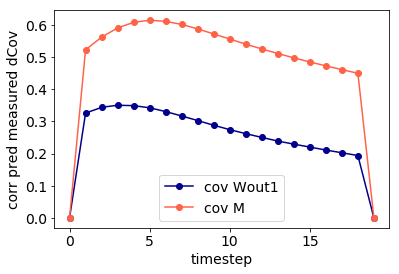

similarity DeltaC1 & dC1_pred_w_out: 0.194
similarity DeltaC1 & dC1_pred_w_m: 0.450


>> CTRL DeltaC1 & CTRL_h1_pre: -0.325
>> CTRL DeltaC1 & CTRL_h1_post: 0.659
>> CTRL DeltaC1 & CTRL_dW1_w_out_h1_post: 0.178
>> CTRL DeltaC1 & CTRL_dW1_w_m_h1_post: 0.403




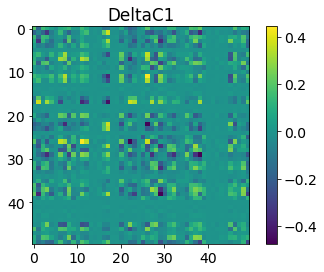

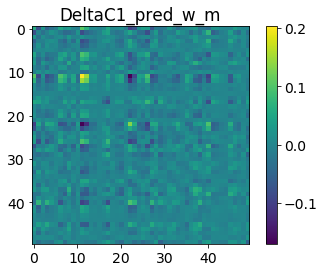

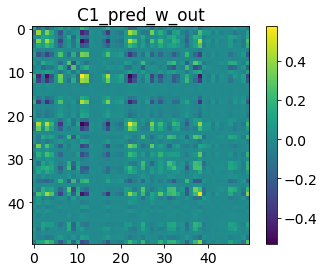

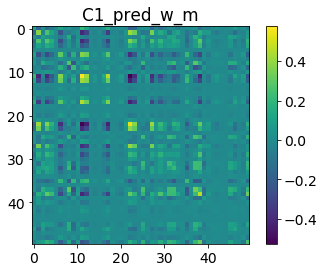

In [25]:
""" Activity During """

""" Covariance Before """
h1_pre = np.asarray(sim1_pre.session_probes['h']).squeeze()


""" Covariance After """
h1_post = np.asarray(sim1_post.session_probes['h']).squeeze()



covariance2 = np.zeros(20)
covariance3 = np.zeros(20)
for t_ind in range(1,19):
    
    C1_pre = np.cov(h1_pre[:,t_ind,:].T) # neurons x trials at a single time point
    C1_post = np.cov(h1_post[:,t_ind,:].T) # neurons x trials at a single time point
    DeltaC1 = C1_post - C1_pre

    h1_train = sim1_train.session_probes['h']
    err1_train = sim1_train.session_probes['err']

    dW1_w_out = flow_field_predicted(net1.w_out,err1_train,h1_train)
    dW1_w_out *= 0.0001 #dW1_w_out/LA.norm(dW1_w_out)
    dW1_w_m = flow_field_predicted(net1.w_m.T,err1_train,h1_train)
    dW1_w_m *= 0.0001 #dW1_w_m/LA.norm(dW1_w_m)

    h1_pre = np.asarray(sim1_pre.session_probes['h']).squeeze()
    h1_post = np.asarray(sim1_post.session_probes['h']).squeeze()

    C1_pred_w_out = np.cov(h1_pre[:,t_ind,:].T + dW1_w_out@(h1_pre[:,t_ind,:].T)) # h1_pre or h1_post?
    C1_pred_w_m = np.cov(h1_pre[:,t_ind,:].T + dW1_w_m@(h1_pre[:,t_ind,:].T))

    dC1_pred_w_out = C1_pred_w_out - C1_pre

    dC1_pred_w_m = C1_pred_w_m - C1_pre
    
    covariance2[t_ind] = np.corrcoef(DeltaC1.ravel(),dC1_pred_w_out.ravel())[0,1]
    covariance3[t_ind] = np.corrcoef(DeltaC1.ravel(),dC1_pred_w_m.ravel())[0,1]
    
    

fig,ax = plt.subplots(1,1)
#plt.plot(np.asarray(covariance1).T,'o-',label='cov Wout0',color='teal')
plt.plot(np.asarray(covariance2).T,'o-',label='cov Wout1',color='darkblue')
plt.plot(np.asarray(covariance3).T,'o-',label='cov M',color='tomato')
plt.legend()
plt.xlabel('timestep')
plt.ylabel('corr pred measured dCov')
plt.show()


print('similarity DeltaC1 & dC1_pred_w_out: {:.3f}'.format(np.corrcoef(DeltaC1.ravel(),dC1_pred_w_out.ravel())[0,1]))
print('similarity DeltaC1 & dC1_pred_w_m: {:.3f}'.format(np.corrcoef(DeltaC1.ravel(),dC1_pred_w_m.ravel())[0,1]))
print('\n')

CTRL_h1_pre = np.cov(h1_pre[:,t_ind,:].T)
CTRL_h1_post = np.cov(h1_post[:,t_ind,:].T)
CTRL_dW1_w_out_h1_post = np.cov(dW1_w_out@(h1_post[:,t_ind,:].T))
CTRL_dW1_w_m_h1_post = np.cov(dW1_w_m@(h1_post[:,t_ind,:].T))

print('>> CTRL DeltaC1 & CTRL_h1_pre: {:.3f}'.format(np.corrcoef(DeltaC1.ravel(),CTRL_h1_pre.ravel())[0,1]))
print('>> CTRL DeltaC1 & CTRL_h1_post: {:.3f}'.format(np.corrcoef(DeltaC1.ravel(),CTRL_h1_post.ravel())[0,1]))
print('>> CTRL DeltaC1 & CTRL_dW1_w_out_h1_post: {:.3f}'.format(np.corrcoef(DeltaC1.ravel(),CTRL_dW1_w_out_h1_post.ravel())[0,1]))
print('>> CTRL DeltaC1 & CTRL_dW1_w_m_h1_post: {:.3f}'.format(np.corrcoef(DeltaC1.ravel(),CTRL_dW1_w_m_h1_post.ravel())[0,1]))

print('\n')


plt.imshow(DeltaC1)
plt.colorbar()
plt.title('DeltaC1')
plt.show()

plt.imshow(dC1_pred_w_m)
plt.colorbar()
plt.title('DeltaC1_pred_w_m')
plt.show()

plt.imshow(C1_pred_w_out)
plt.colorbar()
plt.title('C1_pred_w_out')
plt.show()

plt.imshow(C1_pred_w_m)
plt.colorbar()
plt.title('C1_pred_w_m')
plt.show()

### Calculate Vector Flow Fields

Note here that I am splitting points in neural activity space into training vs. testing points.

In order to make a linear prediction of the "biased" change in flow field, I need to sample error points and activity points during learning. I use vectors `h_train` and `err_train` to do this.

However, in order to make the final correlation between vector flow fields, I need to sample points in activity space and "plug them in" to the predicted and measured vector flow fields. For this I use `h_test`

early fit 0.963, late fit 0.980


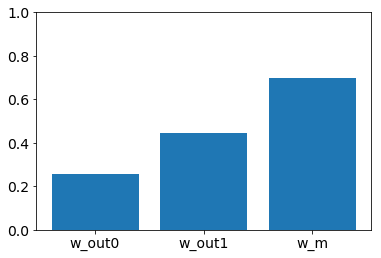

In [9]:
""" Calculate F fields """
F_early, score_early = flow_field_data(sim1_pre.session_probes['h'])
F_late, score_late = flow_field_data(sim1_post.session_probes['h'])

print('early fit {:.3f}, late fit {:.3f}'.format(score_early,score_late))

Fdata = F_late - F_early

# separate train and test data from sim1_train
n_total = len(sim1_train.session_probes['h'])
n_train = int(0.5 * n_total)
idx_train = np.random.RandomState(1964).choice(np.arange(0,n_total),size=n_train,replace=False).astype(int)
idx_test = np.arange(0,n_total)[~idx_train].astype(int)
#idx_test=idx_train

h_train = np.asarray(sim1_train.session_probes['h'])[idx_train,:,:,:]
err_train = np.asarray(sim1_train.session_probes['err'])[idx_train,:,:,:]

Fpred_w_out = flow_field_predicted(net0.w_out,err_train,h_train)
Fpred_w_out1 = flow_field_predicted(w_out1,err_train,h_train)
Fpred_w_m = flow_field_predicted(net1.w_m.T,err_train,h_train)

h_test = np.asarray(sim1_train.session_probes['h'])[idx_test,:,:,:]

corr1 = calculate_flow_field_correlation(Fpred_w_out,Fdata,h_test) # could also sample sim_test
#corr1_list.append(corr1)

corr2 = calculate_flow_field_correlation(Fpred_w_out1,Fdata,h_test) # could also sample sim_test
#corr2_list.append(corr2)

corr3 = calculate_flow_field_correlation(Fpred_w_m,Fdata,h_test) # could also sample sim_test


plt.bar([0,1,2],[corr1,corr2,corr3],tick_label=['w_out0','w_out1','w_m'])
plt.ylim([0,1])
plt.show()

# RFLO, 1 Target Task

In [123]:
# define f and df

def f_linear(x):
    return x

def df_linear(x):
    return 1

21it [00:00, 198.86it/s]

n_in: 4
n_rec: 50
n_out: 2
sig_in: 0.0
sig_rec: 0.25
sig_out: 0.01
tau_rec: 10
dt: 1.0
eta_in: 0.1
eta_rec: 0.1
eta_out: 0.1
g_in: 2.0
g_rec: 0.5
g_out: 2.0
g_fb: 2.0
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: False
tau_vel: 0.8
dt_vel: 0.1
sig_rec_dim: None
eta_m: None
sig_m: None
lam_m: None
rng: <mtrand.RandomState object at 0x7f86dae28e58>


500it [00:01, 444.23it/s]


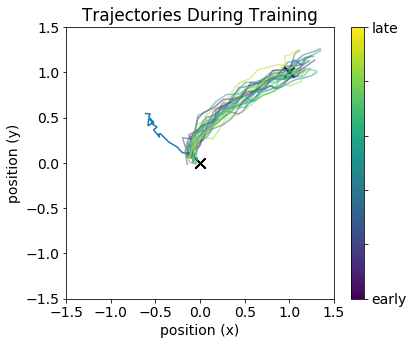

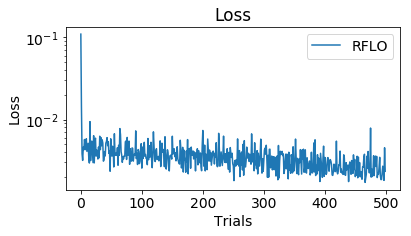

In [216]:
# Set RNN Parameters
params = RNNparams(n_in=4,n_rec=50,n_out=2,tau_rec=10,
               eta_in=0.1,eta_rec=0.1,eta_out=0.1,
               sig_in=0.0,sig_rec=0.25,sig_out=0.01,
               velocity_transform=False, tau_vel = 0.8, dt_vel = 0.1,
               g_rec=0.5,
               rng=np.random.RandomState(8))
params.print_params()

# Initialize RNN
net0 = RNN(params,f=f_linear,df=df_linear)
sim0 = Simulation(net0)
rflo = RFLO(net0,apply_to=['w_rec'],online=False)
sim0.run_session(n_trials=500, tasks=[task1], learn_alg=[rflo], probe_types=['loss'], plot=True, plot_freq=20)




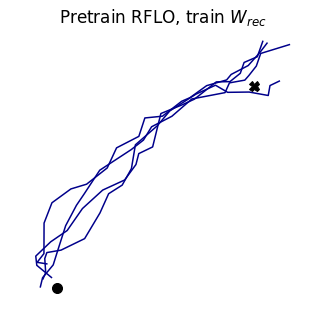

In [217]:
fig0 = plot_trained_trajectories(sim=sim0, tasks=[task1],title='Pretrain RFLO, train '+r'$W_{rec}$')


## Apply gradient calculation to two separate learning rules

First we choose a new decoder `w_out1` such that it has an overlap alignment of 0.6 with the old decoder `w_out0`.

Then we define an "internal model of credit assignment" matrix `w_m` that overlaps with the new decoder by 0.6.

Since these are selected randomly, the overlap of the internal model `w_m` with the old decoder `w_out0` is lower, i.e. 0.3

In [218]:
overlap = 0.6
n_change = 50
w_out1 = choose_aligned_matrix(net0.w_out.copy(),n_change=n_change,overlap=overlap,zero=False,tolerance=0.01,loop=1000)
w_m = choose_aligned_matrix(w_out1,n_change=n_change,overlap=overlap,zero=False,tolerance=0.01,loop=1000)

# confirm overlap between w_out1 and w_out
norm, angle = return_norm_and_angle(net0.w_out,w_out1)
print('\nw_out1 norm: {:.2f}'.format(norm) + '\t w_out vs. w_out1 angle: {:.2f}'.format(angle),end='')

# confirm overlap between w_out1 and w_m
norm, angle = return_norm_and_angle(w_out1,w_m)
print('\nw_m norm: {:.2f}'.format(norm) + '\t w_out1 vs. w_m angle: {:.2f}'.format(angle),end='')

# confirm overlap between w_out and w_m
norm, angle = return_norm_and_angle(net0.w_out,w_m)
print('\nw_m norm: {:.2f}'.format(norm) + '\t w_out vs. w_m angle: {:.2f}'.format(angle),end='')

M norm: 1.06	 M angle: 0.60, 1 iterations
w_out1 norm: 1.34	 w_out vs. w_out1 angle: 0.59
w_m norm: 1.06	 w_out1 vs. w_m angle: 0.60
w_m norm: 1.48	 w_out vs. w_m angle: 0.47

## Train with RFLO

500it [00:00, 862.64it/s]
500it [00:01, 370.25it/s]
500it [00:00, 857.68it/s]


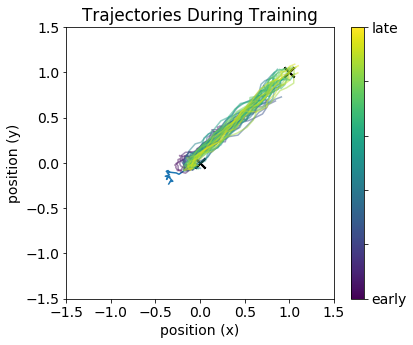

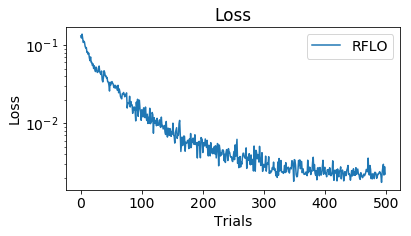

In [249]:
net1_pre = RNN(params)
net1_pre.set_weights(w_in=net0.w_in.copy(), w_rec=net0.w_rec.copy())
net1_pre.set_weights(w_out = w_out1)
net1_pre.set_weights(w_m = w_m.T)

# unfortunately I need to make a different network to maintain integrity of pre and post simulations for plotting
net1 = RNN(params)
net1.set_weights(w_in=net0.w_in.copy(), w_rec=net0.w_rec.copy())
net1.set_weights(w_out = w_out1)
net1.set_weights(w_m = w_m.T)




""" Track activity with new decoder, before training """

sim1_pre = Simulation(net1_pre)
trackvars = TrackVars(net1_pre,apply_to=[]) 
sim1_pre.run_session(n_trials=500, tasks=[task1], learn_alg=[trackvars], probe_types=['h','err','w_rec'], plot=False, plot_freq=10)
#fig = plot_trained_trajectories(sim=sim1_pre, tasks=[task1,task2,task3,task4],title='RFLO, before training with new decoder')

""" Train with new decoder """

sim1_train = Simulation(net1)
rflo = RFLO(net1,apply_to=['w_rec'],online=False)
sim1_train.run_session(n_trials=500, tasks=[task1], learn_alg=[rflo], probe_types=['h','loss','err','w_rec'], plot=True, plot_freq=10)

""" Track activity with new decoder, after training """
net1_post = RNN(params)
net1_post.set_weights(w_in=net1.w_in.copy(), w_rec=net1.w_rec.copy())
net1_post.set_weights(w_out = net1.w_out)
net1_post.set_weights(w_m = net1.w_m)

sim1_post = Simulation(net1_post)
trackvars = TrackVars(net1_post,apply_to=[]) 
sim1_post.run_session(n_trials=500, tasks=[task1], learn_alg=[trackvars], probe_types=['h','err','w_rec'], plot=False, plot_freq=10)


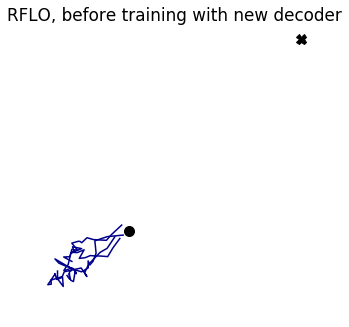

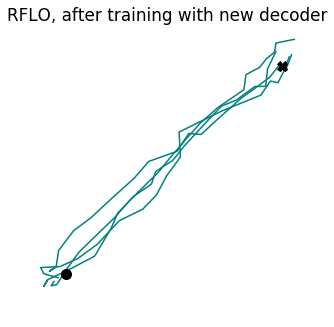

In [250]:
fig = plot_trained_trajectories(sim=sim1_pre, tasks=[task1],title='RFLO, before training with new decoder')

fig = plot_trained_trajectories(sim=sim1_post, tasks=[task1],title='RFLO, after training with new decoder')


similarity pre post: 0.989


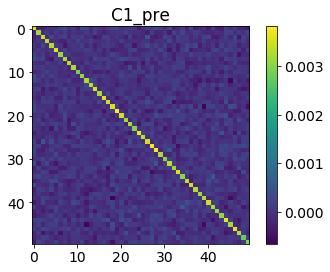

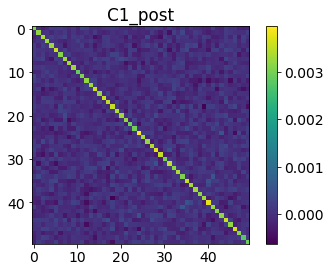

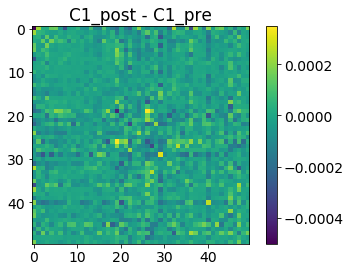

In [251]:
t_ind = 19

""" Covariance Before """
h1_pre = np.asarray(sim1_pre.session_probes['h']).squeeze()

C1_pre = np.cov(h1_pre[:,t_ind,:].T) # neurons x trials at a single time point

""" Covariance After """
h1_post = np.asarray(sim1_post.session_probes['h']).squeeze()

C1_post = np.cov(h1_post[:,t_ind,:].T) # neurons x trials at a single time point


DeltaC1 = C1_post - C1_pre
#DeltaC1 = C1_post/LA.norm(C1_post) - C1_pre/LA.norm(C1_pre) # I don't think it makes sense to normalize here!

print('similarity pre post: {:.3f}'.format(np.corrcoef(C1_post.ravel(),C1_pre.ravel())[0,1]))

plt.imshow(C1_pre)
plt.colorbar()
plt.title('C1_pre')
plt.show()


plt.imshow(C1_post)
plt.colorbar()
plt.title('C1_post')
plt.show()

plt.imshow(DeltaC1)
plt.colorbar()
plt.title('C1_post - C1_pre')
plt.show()

>>> t_ind should be the same!
similarity DeltaC1 & C1_pred_w_out: 0.141
similarity DeltaC1 & C1_pred_w_m: 0.274


>> CTRL DeltaC1 & CTRL_h1_pre: 0.014
>> CTRL DeltaC1 & CTRL_h1_post: 0.139
>> CTRL DeltaC1 & CTRL_dW1_w_out_h1_post: 0.132
>> CTRL DeltaC1 & CTRL_dW1_w_m_h1_post: 0.264




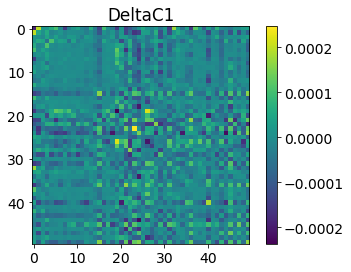

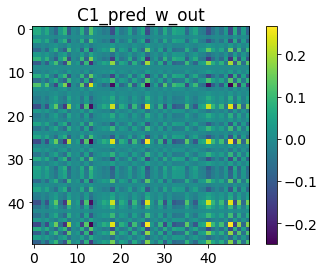

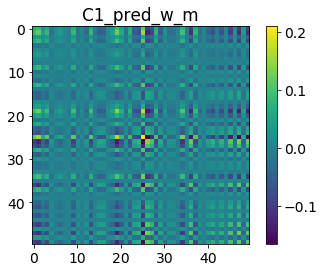

In [252]:
""" Activity During """
t_ind = 10
print('>>> t_ind should be the same!')
trials = slice(750,1500)

""" Covariance Before """
h1_pre = np.asarray(sim1_pre.session_probes['h']).squeeze()
C1_pre = np.cov(h1_pre[:,t_ind,:].T) # neurons x trials at a single time point

""" Covariance After """
h1_post = np.asarray(sim1_post.session_probes['h']).squeeze()
C1_post = np.cov(h1_post[:,t_ind,:].T) # neurons x trials at a single time point


DeltaC1 = C1_post - C1_pre


h1_train = sim1_train.session_probes['h']
err1_train = sim1_train.session_probes['err']

dW1_w_out = flow_field_predicted(net1.w_out,err1_train,h1_train)
dW1_w_out *= 0.01 #dW1_w_out/LA.norm(dW1_w_out)
dW1_w_m = flow_field_predicted(net1.w_m.T,err1_train,h1_train)
dW1_w_m *= 0.01 #dW1_w_m/LA.norm(dW1_w_m)

# h1_pre = np.asarray(sim1_pre.session_probes['h']).squeeze()
# h1_post = np.asarray(sim1_post.session_probes['h']).squeeze()

C1_pred_w_out = np.cov(h1_pre[:,t_ind,:].T + dW1_w_out@(h1_post[:,t_ind,:].T))
C1_pred_w_m = np.cov(h1_pre[:,t_ind,:].T + dW1_w_m@(h1_post[:,t_ind,:].T))



print('similarity DeltaC1 & C1_pred_w_out: {:.3f}'.format(np.corrcoef(DeltaC1.ravel(),C1_pred_w_out.ravel())[0,1]))
print('similarity DeltaC1 & C1_pred_w_m: {:.3f}'.format(np.corrcoef(DeltaC1.ravel(),C1_pred_w_m.ravel())[0,1]))
print('\n')

CTRL_h1_pre = np.cov(h1_pre[:,t_ind,:].T)
CTRL_h1_post = np.cov(h1_post[:,t_ind,:].T)
CTRL_dW1_w_out_h1_post = np.cov(dW1_w_out@(h1_post[:,t_ind,:].T))
CTRL_dW1_w_m_h1_post = np.cov(dW1_w_m@(h1_post[:,t_ind,:].T))

print('>> CTRL DeltaC1 & CTRL_h1_pre: {:.3f}'.format(np.corrcoef(DeltaC1.ravel(),CTRL_h1_pre.ravel())[0,1]))
print('>> CTRL DeltaC1 & CTRL_h1_post: {:.3f}'.format(np.corrcoef(DeltaC1.ravel(),CTRL_h1_post.ravel())[0,1]))
print('>> CTRL DeltaC1 & CTRL_dW1_w_out_h1_post: {:.3f}'.format(np.corrcoef(DeltaC1.ravel(),CTRL_dW1_w_out_h1_post.ravel())[0,1]))
print('>> CTRL DeltaC1 & CTRL_dW1_w_m_h1_post: {:.3f}'.format(np.corrcoef(DeltaC1.ravel(),CTRL_dW1_w_m_h1_post.ravel())[0,1]))

print('\n')


plt.imshow(DeltaC1)
plt.colorbar()
plt.title('DeltaC1')
plt.show()

plt.imshow(C1_pred_w_out)
plt.colorbar()
plt.title('C1_pred_w_out')
plt.show()

plt.imshow(C1_pred_w_m)
plt.colorbar()
plt.title('C1_pred_w_m')
plt.show()

number of trials:  500


Text(0.5, 1.0, 'RFLO, 1 Target, Train W_rec')

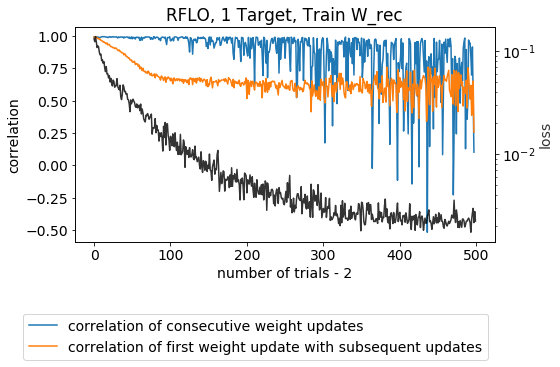

In [234]:
""" Analyze weight updates"""

fig,ax = plt.subplots(1,1,figsize=(8,4))



W = sim1_train.session_probes['w_rec']
print('number of trials: ',len(W))

n_trials = len(W)

""" correlation with subsequent update"""
corrs = []
for n in range(n_trials-2):
    deltaW1 = W[n+1][0] - W[n][0] # previous change/update
    deltaW2 = W[n+2][0] - W[n+1][0] # subsequent change/update

    corrs.append(np.corrcoef(deltaW1.ravel(),deltaW2.ravel())[0,1])
    
ax.plot(corrs,'-',label='correlation of consecutive weight updates')
#plt.ylim([0,1.2])

""" correlation with later updates"""
corrs = []
for n in range(n_trials-2):
    deltaW1 = W[1][0] - W[0][0]
    deltaW2 = W[n+2][0] - W[n+1][0]

    corrs.append(np.corrcoef(deltaW1.ravel(),deltaW2.ravel())[0,1])
    
ax.plot(corrs,'-',label='correlation of first weight update with subsequent updates')
#ax.set_ylim(bottom=0)
ax.set_xlabel('number of trials - 2')
ax.set_ylabel('correlation')

#ax1.set_ylim(top=0.2)

ax1 = ax.twinx()
loss = np.mean(np.asarray(sim1_train.session_probes['loss']),axis=1)
#std = np.std(np.asarray(sim.session_probes['loss']),axis=1)
ax1.plot(loss,color='k',alpha=0.8)
#ax1.fill_between(np.arange(len(loss)),loss-std,loss+std,alpha=0.2)
ax1.set_ylabel('loss',color='k',alpha=0.8)
ax1.set_yscale('log')
#ax1.set_ylim(top=np.max(loss))
plt.tight_layout()
ax.legend(bbox_to_anchor=(1,-0.3))

ax.set_title('RFLO, 1 Target, Train W_rec')



number of trials:  500
n_samples,n_features:  (499, 2500)
C:  (10, 2500)


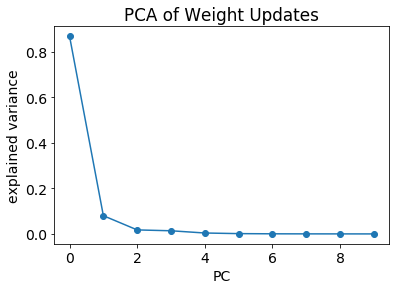

In [255]:
""" PCA on the weight updates """

# concatenate data
W = sim1_train.session_probes['w_rec']
print('number of trials: ',len(W))

n_trials = len(W)

""" correlation with subsequent update"""
deltaW = []
deltaW.append((W[1][0] - W[0][0]).ravel())
for n in np.arange(1,n_trials-1):
    deltaW = np.vstack((deltaW,(W[n+1][0] - W[n][0]).ravel()))
    
print('n_samples,n_features: ',deltaW.shape)

pca = PCA(n_components=10)
pca.fit(deltaW)
C = pca.components_

print('C: ',pca.components_.shape)
# #plt.plot(pca.explained_variance_/np.sum(pca.explained_variance_),'o-') # same dealio
plt.plot(pca.explained_variance_ratio_,'o-')
plt.ylabel('explained variance')
plt.xlabel('PC')
plt.title('PCA of Weight Updates')
plt.show()

Text(0.5, 2.0, 'trials')

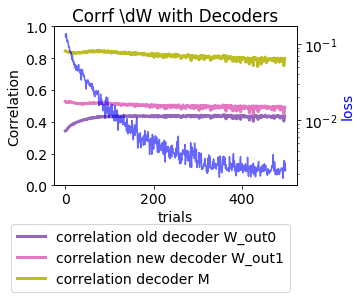

In [267]:
fig,ax = plt.subplots(1,1,figsize=(5,3))

ax1 = ax.twinx()
loss = np.mean(np.asarray(sim1_train.session_probes['loss']),axis=1)
#std = np.std(np.asarray(sim.session_probes['loss']),axis=1)
ax1.plot(loss,color='b',alpha=0.6)
#ax1.fill_between(np.arange(len(loss)),loss-std,loss+std,alpha=0.2)
ax1.set_ylabel('loss',color='b')
ax1.set_yscale('log')

""" correlation with W_out.T using average error """
#av_error = np.mean(np.asarray(sim1_train.session_probes['err']),axis=0).squeeze() # positions at trial n

delta_W_all = []
corrs_w_out0=[]
corrs_w_out=[]
corrs_w_m=[]
for n in range(n_trials-2):
    deltaW1 = W[n+1][0] - W[n][0]
    
    delta_W_all.append(deltaW1)
    error = sim1_train.session_probes['err'][n].squeeze() # positions at trial n

    
    activity = sim1_train.session_probes['h'][n].squeeze() # activity at trial n
    delta_w_out0 = np.outer(net0.w_out.T @ np.sum(error,axis=0), np.sum(activity,axis=0)) # old decoder
    delta_w_out = np.outer(net1.w_out.T @ np.sum(error,axis=0), np.sum(activity,axis=0)) # new decoder
    delta_w_m = np.outer(net1.w_m @ np.sum(error,axis=0), np.sum(activity,axis=0)) # internal model
    
    delta_W_av = np.mean(np.asarray(delta_W_all),axis=0)
    
#     corrs_w_out.append(np.corrcoef(delta_W_av.ravel(),delta_w_out.ravel())[0,1])
#     corrs_w_m.append(np.corrcoef(delta_W_av.ravel(),delta_w_m.ravel())[0,1])

    
    """ not the average """
#     corrs_w_out0.append(np.corrcoef(deltaW1.ravel(),delta_w_out0.ravel())[0,1])
#     corrs_w_out.append(np.corrcoef(deltaW1.ravel(),delta_w_out.ravel())[0,1])
#     corrs_w_m.append(np.corrcoef(deltaW1.ravel(),delta_w_m.ravel())[0,1])
    
    
    """ average """
    corrs_w_out0.append(np.corrcoef(delta_W_av.ravel(),delta_w_out0.ravel())[0,1])
    corrs_w_out.append(np.corrcoef(delta_W_av.ravel(),delta_w_out.ravel())[0,1])
    corrs_w_m.append(np.corrcoef(delta_W_av.ravel(),delta_w_m.ravel())[0,1])

ax.plot(corrs_w_out0,'-',label='correlation old decoder W_out0',color='C4',linewidth=3)
ax.plot(corrs_w_out,'-',label='correlation new decoder W_out1',color='C6',linewidth=3)
ax.plot(corrs_w_m,'-',label='correlation decoder M',color='C8',linewidth=3)
ax.set_ylim([0,1])


#ax1.set_ylim(top=np.max(loss))
plt.tight_layout()
ax.legend(bbox_to_anchor=(1,-0.2))
plt.title('Corr \dW with Decoders')
ax.set_ylabel('Correlation')
ax.set_xlabel('trials')

# REINFORCE

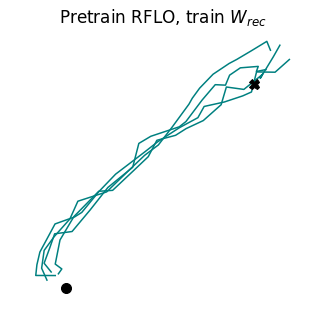

In [219]:
fig0 = plot_trained_trajectories(sim=sim0, tasks=[task1],title='Pretrain RFLO, train '+r'$W_{rec}$')


## Apply gradient calculation to two separate learning rules

First we choose a new decoder `w_out1` such that it has an overlap alignment of 0.6 with the old decoder `w_out0`.

Then we define an "internal model of credit assignment" matrix `w_m` that overlaps with the new decoder by 0.6.

Since these are selected randomly, the overlap of the internal model `w_m` with the old decoder `w_out0` is lower, i.e. 0.3

## Train with REINFORCE

500it [00:00, 808.98it/s]
2000it [00:04, 414.72it/s]
500it [00:00, 842.17it/s]


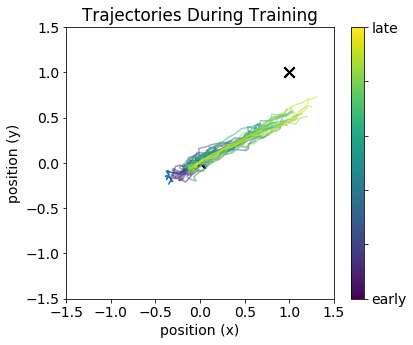

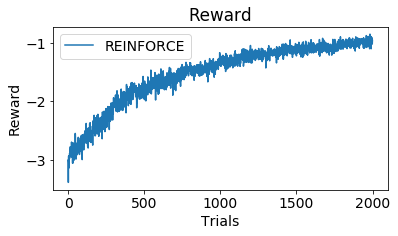

In [238]:
net1_pre = RNN(params)
net1_pre.set_weights(w_in=net0.w_in.copy(), w_rec=net0.w_rec.copy())
net1_pre.set_weights(w_out = w_out1)
net1_pre.set_weights(w_m = w_m.T)

# unfortunately I need to make a different network to maintain integrity of pre and post simulations for plotting
net1 = RNN(params)
net1.set_weights(w_in=net0.w_in.copy(), w_rec=net0.w_rec.copy())
net1.set_weights(w_out = w_out1)
net1.set_weights(w_m = w_m.T)




""" Track activity with new decoder, before training """

sim1_pre = Simulation(net1_pre)
trackvars = TrackVars(net1_pre,apply_to=[]) 
sim1_pre.run_session(n_trials=500, tasks=[task1], learn_alg=[trackvars], probe_types=['h','err','w_rec'], plot=False, plot_freq=10)
#fig = plot_trained_trajectories(sim=sim1_pre, tasks=[task1,task2,task3,task4],title='RFLO, before training with new decoder')

""" Train with new decoder """

sim1_train = Simulation(net1)
reinforce = REINFORCE(net1,apply_to=['w_rec'],online=False,tau_reward=5)
sim1_train.run_session(n_trials=2000, tasks=[task1], learn_alg=[reinforce], probe_types=['h','reward','err','w_rec'], plot=True, plot_freq=50)

""" Track activity with new decoder, after training """
net1_post = RNN(params)
net1_post.set_weights(w_in=net1.w_in.copy(), w_rec=net1.w_rec.copy())
net1_post.set_weights(w_out = net1.w_out)
net1_post.set_weights(w_m = net1.w_m)

sim1_post = Simulation(net1_post)
trackvars = TrackVars(net1_post,apply_to=[]) 
sim1_post.run_session(n_trials=500, tasks=[task1], learn_alg=[trackvars], probe_types=['h','err','w_rec'], plot=False, plot_freq=10)


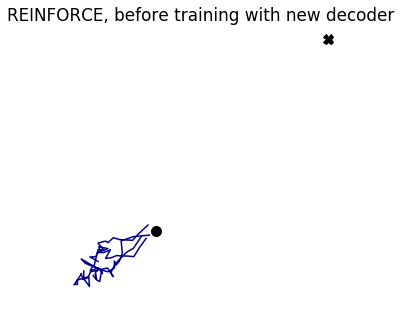

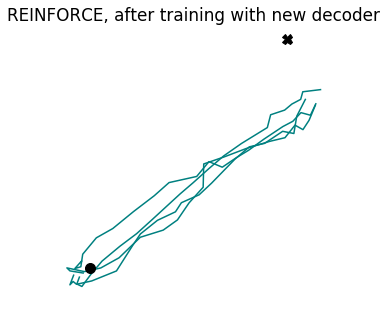

In [239]:
fig = plot_trained_trajectories(sim=sim1_pre, tasks=[task1],title='REINFORCE, before training with new decoder')

fig = plot_trained_trajectories(sim=sim1_post, tasks=[task1],title='REINFORCE, after training with new decoder')


similarity pre post: 0.993


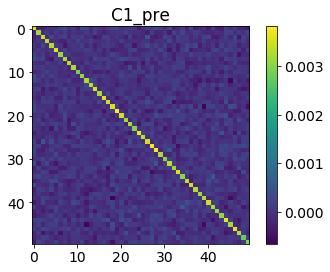

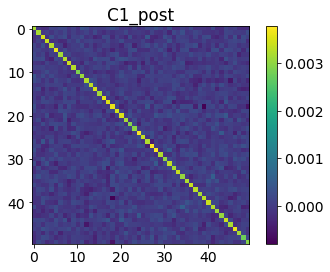

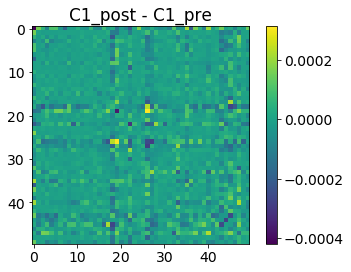

In [240]:
t_ind = 19

""" Covariance Before """
h1_pre = np.asarray(sim1_pre.session_probes['h']).squeeze()

C1_pre = np.cov(h1_pre[:,t_ind,:].T) # neurons x trials at a single time point

""" Covariance After """
h1_post = np.asarray(sim1_post.session_probes['h']).squeeze()

C1_post = np.cov(h1_post[:,t_ind,:].T) # neurons x trials at a single time point


DeltaC1 = C1_post - C1_pre
#DeltaC1 = C1_post/LA.norm(C1_post) - C1_pre/LA.norm(C1_pre) # I don't think it makes sense to normalize here!

print('similarity pre post: {:.3f}'.format(np.corrcoef(C1_post.ravel(),C1_pre.ravel())[0,1]))

plt.imshow(C1_pre)
plt.colorbar()
plt.title('C1_pre')
plt.show()


plt.imshow(C1_post)
plt.colorbar()
plt.title('C1_post')
plt.show()

plt.imshow(DeltaC1)
plt.colorbar()
plt.title('C1_post - C1_pre')
plt.show()

>>> t_ind should be the same!
similarity DeltaC1 & C1_pred_w_out: -0.005
similarity DeltaC1 & C1_pred_w_m: -0.061


>> CTRL DeltaC1 & CTRL_h1_pre: -0.203
>> CTRL DeltaC1 & CTRL_h1_post: -0.084
>> CTRL DeltaC1 & CTRL_dW1_w_out_h1_post: -0.005
>> CTRL DeltaC1 & CTRL_dW1_w_m_h1_post: -0.061




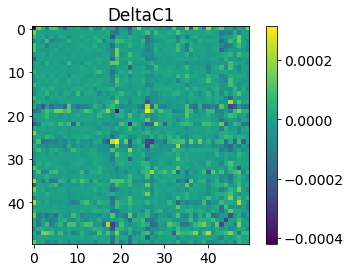

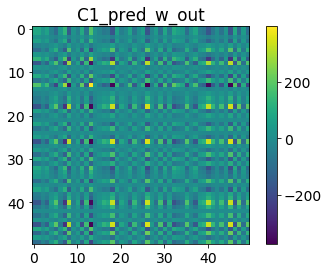

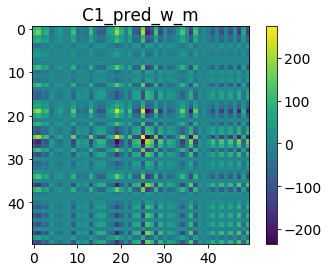

In [241]:
""" Activity During """
t_ind = 19
print('>>> t_ind should be the same!')

""" Covariance Before """
h1_pre = np.asarray(sim1_pre.session_probes['h']).squeeze()
C1_pre = np.cov(h1_pre[:,t_ind,:].T) # neurons x trials at a single time point

""" Covariance After """
h1_post = np.asarray(sim1_post.session_probes['h']).squeeze()
C1_post = np.cov(h1_post[:,t_ind,:].T) # neurons x trials at a single time point


DeltaC1 = C1_post - C1_pre


h1_train = sim1_train.session_probes['h']
err1_train = sim1_train.session_probes['err']

dW1_w_out = flow_field_predicted(net1.w_out,err1_train,h1_train)
dW1_w_out *= 0.01 #dW1_w_out/LA.norm(dW1_w_out)
dW1_w_m = flow_field_predicted(net1.w_m.T,err1_train,h1_train)
dW1_w_m *= 0.01 #dW1_w_m/LA.norm(dW1_w_m)

# h1_pre = np.asarray(sim1_pre.session_probes['h']).squeeze()
# h1_post = np.asarray(sim1_post.session_probes['h']).squeeze()

C1_pred_w_out = np.cov(h1_pre[:,t_ind,:].T + dW1_w_out@(h1_post[:,t_ind,:].T))
C1_pred_w_m = np.cov(h1_pre[:,t_ind,:].T + dW1_w_m@(h1_post[:,t_ind,:].T))



print('similarity DeltaC1 & C1_pred_w_out: {:.3f}'.format(np.corrcoef(DeltaC1.ravel(),C1_pred_w_out.ravel())[0,1]))
print('similarity DeltaC1 & C1_pred_w_m: {:.3f}'.format(np.corrcoef(DeltaC1.ravel(),C1_pred_w_m.ravel())[0,1]))
print('\n')

CTRL_h1_pre = np.cov(h1_pre[:,t_ind,:].T)
CTRL_h1_post = np.cov(h1_post[:,t_ind,:].T)
CTRL_dW1_w_out_h1_post = np.cov(dW1_w_out@(h1_post[:,t_ind,:].T))
CTRL_dW1_w_m_h1_post = np.cov(dW1_w_m@(h1_post[:,t_ind,:].T))

print('>> CTRL DeltaC1 & CTRL_h1_pre: {:.3f}'.format(np.corrcoef(DeltaC1.ravel(),CTRL_h1_pre.ravel())[0,1]))
print('>> CTRL DeltaC1 & CTRL_h1_post: {:.3f}'.format(np.corrcoef(DeltaC1.ravel(),CTRL_h1_post.ravel())[0,1]))
print('>> CTRL DeltaC1 & CTRL_dW1_w_out_h1_post: {:.3f}'.format(np.corrcoef(DeltaC1.ravel(),CTRL_dW1_w_out_h1_post.ravel())[0,1]))
print('>> CTRL DeltaC1 & CTRL_dW1_w_m_h1_post: {:.3f}'.format(np.corrcoef(DeltaC1.ravel(),CTRL_dW1_w_m_h1_post.ravel())[0,1]))

print('\n')


plt.imshow(DeltaC1)
plt.colorbar()
plt.title('DeltaC1')
plt.show()

plt.imshow(C1_pred_w_out)
plt.colorbar()
plt.title('C1_pred_w_out')
plt.show()

plt.imshow(C1_pred_w_m)
plt.colorbar()
plt.title('C1_pred_w_m')
plt.show()

number of trials:  2000


Text(0.5, 1.0, 'REINFORCE, 1 Target, Train W_rec')

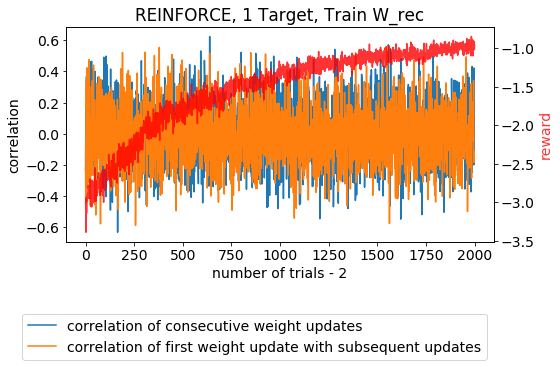

In [227]:
""" Analyze weight updates"""

fig,ax = plt.subplots(1,1,figsize=(8,4))



W = sim1_train.session_probes['w_rec']
print('number of trials: ',len(W))

n_trials = len(W)

""" correlation with subsequent update"""
corrs = []
for n in range(n_trials-2):
    deltaW1 = W[n+1][0] - W[n][0] # previous change/update
    deltaW2 = W[n+2][0] - W[n+1][0] # subsequent change/update

    corrs.append(np.corrcoef(deltaW1.ravel(),deltaW2.ravel())[0,1])
    
ax.plot(corrs,'-',label='correlation of consecutive weight updates')
#plt.ylim([0,1.2])

""" correlation with later updates"""
corrs = []
for n in range(n_trials-2):
    deltaW1 = W[1][0] - W[0][0]
    deltaW2 = W[n+2][0] - W[n+1][0]

    corrs.append(np.corrcoef(deltaW1.ravel(),deltaW2.ravel())[0,1])
    
ax.plot(corrs,'-',label='correlation of first weight update with subsequent updates')
#ax.set_ylim(bottom=0)
ax.set_xlabel('number of trials - 2')
ax.set_ylabel('correlation')

#ax1.set_ylim(top=0.2)

ax1 = ax.twinx()
reward = np.mean(np.asarray(sim1_train.session_probes['reward']),axis=1)
#std = np.std(np.asarray(sim.session_probes['loss']),axis=1)
ax1.plot(reward,color='r',alpha=0.8)
#ax1.fill_between(np.arange(len(loss)),loss-std,loss+std,alpha=0.2)
ax1.set_ylabel('reward',color='red',alpha=0.8)
#ax1.set_ylim(top=np.max(loss))
plt.tight_layout()
ax.legend(bbox_to_anchor=(1,-0.3))

ax.set_title('REINFORCE, 1 Target, Train W_rec')



number of trials:  2000
n_samples,n_features:  (1999, 2500)
C:  (50, 2500)


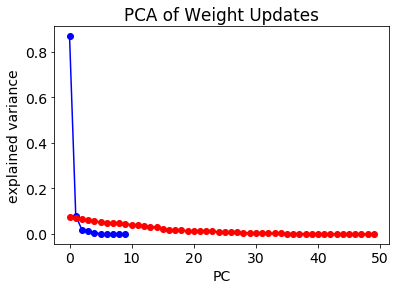

In [242]:
""" PCA on the weight updates """

rflo_pca = pca.explained_variance_ratio_

# concatenate data
W = sim1_train.session_probes['w_rec']
print('number of trials: ',len(W))

n_trials = len(W)

""" correlation with subsequent update"""
deltaW = []
deltaW.append((W[1][0] - W[0][0]).ravel())
for n in np.arange(1,n_trials-1):
    deltaW = np.vstack((deltaW,(W[n+1][0] - W[n][0]).ravel()))
    
print('n_samples,n_features: ',deltaW.shape)

pca = PCA(n_components=50)
pca.fit(deltaW)
C = pca.components_

print('C: ',pca.components_.shape)
# #plt.plot(pca.explained_variance_/np.sum(pca.explained_variance_),'o-') # same dealio


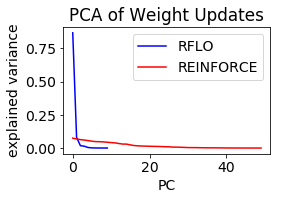

In [248]:
fig,ax=plt.subplots(1,1,figsize=(4,3))
plt.plot(rflo_pca,'-',color='b',label='RFLO')
plt.plot(pca.explained_variance_ratio_,'-',color='r',label='REINFORCE')
plt.ylabel('explained variance')
plt.xlabel('PC')
plt.legend()
plt.title('PCA of Weight Updates')
plt.tight_layout()
plt.show()


Text(0.5, 11.0, 'trials')

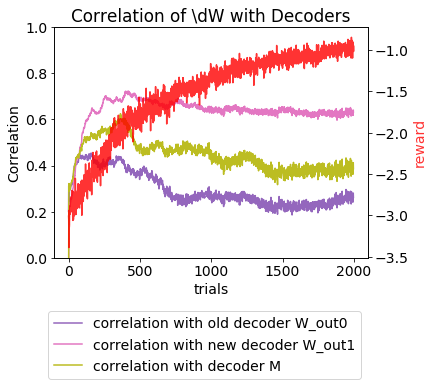

In [229]:
fig,ax = plt.subplots(1,1,figsize=(6,4))



""" correlation with W_out.T using average error """
#av_error = np.mean(np.asarray(sim1_train.session_probes['err']),axis=0).squeeze() # positions at trial n

delta_W_all = []
corrs_w_out0=[]
corrs_w_out=[]
corrs_w_m=[]
for n in range(n_trials-2):
    deltaW1 = W[n+1][0] - W[n][0]
    
    delta_W_all.append(deltaW1)
    error = sim1_train.session_probes['err'][n].squeeze() # positions at trial n

    
    activity = sim1_train.session_probes['h'][n].squeeze() # activity at trial n
    delta_w_out0 = np.outer(net0.w_out.T @ np.sum(error,axis=0), np.sum(activity,axis=0)) # old decoder
    delta_w_out = np.outer(net1.w_out.T @ np.sum(error,axis=0), np.sum(activity,axis=0)) # new decoder
    delta_w_m = np.outer(net1.w_m @ np.sum(error,axis=0), np.sum(activity,axis=0)) # internal model
    
    delta_W_av = np.mean(np.asarray(delta_W_all),axis=0)
    
#     corrs_w_out.append(np.corrcoef(delta_W_av.ravel(),delta_w_out.ravel())[0,1])
#     corrs_w_m.append(np.corrcoef(delta_W_av.ravel(),delta_w_m.ravel())[0,1])
    
    """ not the average """
    corrs_w_out0.append(np.corrcoef(delta_W_av.ravel(),delta_w_out0.ravel())[0,1])
    corrs_w_out.append(np.corrcoef(delta_W_av.ravel(),delta_w_out.ravel())[0,1])
    corrs_w_m.append(np.corrcoef(delta_W_av.ravel(),delta_w_m.ravel())[0,1])

plt.plot(corrs_w_out0,'-',label='correlation with old decoder W_out0',color='C4')
plt.plot(corrs_w_out,'-',label='correlation with new decoder W_out1',color='C6')
plt.plot(corrs_w_m,'-',label='correlation with decoder M',color='C8')
plt.ylim([0,1])

ax1 = ax.twinx()
reward = np.mean(np.asarray(sim1_train.session_probes['reward']),axis=1)
#std = np.std(np.asarray(sim.session_probes['loss']),axis=1)
ax1.plot(reward,color='r',alpha=0.8)
#ax1.fill_between(np.arange(len(loss)),loss-std,loss+std,alpha=0.2)
ax1.set_ylabel('reward',color='r',alpha=0.8)
#ax1.set_yscale('log')
#ax1.set_ylim(top=np.max(loss))
plt.tight_layout()
ax.legend(bbox_to_anchor=(1,-0.2))
plt.title('Correlation of \dW with Decoders')
ax.set_ylabel('Correlation')
ax.set_xlabel('trials')